# Bootstrapping Yield Curve from T-Bonds and STRIPs

## Loading Data

In [1]:
#Importing all the necessary libraries

import numpy as np
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import datetime
import collections
import requests
from bs4 import BeautifulSoup
import json

In [2]:
#defining a custom function to scrape required data from https://www.wsj.com/market-data/bonds/treasuries

def scrape_data():
    #The function is specifically written for scraping treasury notes prices
    #data from wsj.com website
    mostActiveStocksUrl = "https://www.wsj.com/market-data/bonds/treasuries"
    page = requests.get(mostActiveStocksUrl, headers={'User-Agent': 'Custom'})
    data = page.text
    soup = BeautifulSoup(page.content, 'html.parser')
    rows = soup.find_all('script') # we get all the script tags
    importantJson = ''

    for r in rows:
        text = r.text
        if 'mdc_treasury_' in text: # the scirpt tags containing the date,
            importantJson = text
            break

    importantJson = importantJson\
        .replace('window.__STATE__ =', '')\
        .replace(';', '')\
        .strip()

    jsn = json.loads(importantJson)
    df_data = pd.json_normalize(jsn['data']['mdc_treasury_{\"treasury\":\"NOTES_AND_BONDS\"}']['data']['data']['instruments'])
    
    #re-order the columns of the extracted data to match the order of data
    #reflected in the website
    cols = ['maturityDate','coupon','bid','ask','change','askYield']
    df_data = df_data[cols]
    
    #Change the names of the columns of the extracted data to match the names that are 
    #reflected in the website
    df_data.columns = ['MATURITY','COUPON', 'BID', 'ASKED', 'CHG', 'ASKED YIELD']
    
    #filter data to remove NA values
    df_data = df_data[df_data['BID'] != "n.a."]
    
    #Change the type of variables of Maturity date to pandas datetime and coupon, bid and asked
    #price to numeric
    df_data['MATURITY'] = pd.to_datetime(df_data['MATURITY'].astype(str))
    df_data[['COUPON', 'BID', 'ASKED']] = df_data[['COUPON', 'BID', 'ASKED']].apply(pd.to_numeric)
    df_data = df_data[df_data['BID'] != 0]
    #df_data.set_index("maturityDate", inplace=True)
    #df_data.index = pd.to_datetime(df_data.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
    return df_data

In [3]:
#Load the prices of STRIPs 
STRIPs = pd.read_csv("C:/Users/bhask/Downloads/TreasuryZeros Details.csv")
STRIPs['Maturity'] = pd.to_datetime(STRIPs['Maturity'].astype(str))

STRIPs_data = pd.DataFrame()
STRIPs_data['MATURITY'] = STRIPs['Maturity']
STRIPs_data['COUPON'] = 0
STRIPs_data['BID'] = STRIPs['Price']
STRIPs_data['ASKED'] = STRIPs['Price'] 
STRIPs_data['CHG'] = 'unch.'
STRIPs_data['ASKED YIELD'] = STRIPs['YTM']

STRIPs_data = STRIPs_data[STRIPs_data['BID'] != "--"]

STRIPs_data[['COUPON', 'BID', 'ASKED']] = STRIPs_data[['COUPON', 'BID', 'ASKED']].apply(pd.to_numeric)

STRIPs_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
0,2020-11-15,0,100.099,100.099,unch.,-0.607
1,2021-02-15,0,100.066,100.066,unch.,-0.16
2,2021-02-15,0,100.085,100.085,unch.,-0.206
3,2021-05-15,0,100.044,100.044,unch.,-0.066
4,2021-05-15,0,100.059,100.059,unch.,-0.089


In [4]:
#Running the scrape_data() function created above and storing the data in a variable
TBond_data = scrape_data()

In [5]:
#Back-up of copying the data to python through csv files in case web scraping doesn't work

#TBond_data = pd.read_csv("C:/Users/bhask/Downloads/NYU/Sem 1 Fall 2020/FRE-GY6103 - Valuation/Week 2/WSJ T-Bond Data.csv")
#TBond_data['MATURITY'] = pd.to_datetime(TBond_data['MATURITY'].astype(str))
#TBond_data = TBond_data[TBond_data['MATURITY'].dt.day == 15] 

In [6]:
TBond_data.shape

(313, 6)

In [7]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
0,2020-09-30,1.375,100.012,100.016,-0.0020,-0.2907
1,2020-09-30,2.000,100.020,100.024,unch.,-0.3786
2,2020-09-30,2.750,100.026,100.032,0.0020,-0.3426
3,2020-10-15,1.625,100.034,100.040,0.0020,-0.069
4,2020-10-31,1.375,100.044,100.050,unch.,0.038


In [8]:
TBond_data.tail()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
308,2049-08-15,2.250,119.280,119.300,0.1840,1.408
309,2049-11-15,2.375,123.022,123.042,0.8700,1.405
310,2050-02-15,2.000,114.014,114.034,0.8640,1.412
311,2050-05-15,1.250,95.206,95.226,0.1600,1.428
312,2050-08-15,1.375,98.236,98.256,0.1740,1.424


In [9]:
TBond_data = pd.concat([TBond_data, STRIPs_data], axis=0)

In [10]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
0,2020-09-30,1.375,100.012,100.016,-0.0020,-0.2907
1,2020-09-30,2.000,100.020,100.024,unch.,-0.3786
2,2020-09-30,2.750,100.026,100.032,0.0020,-0.3426
3,2020-10-15,1.625,100.034,100.040,0.0020,-0.069
4,2020-10-31,1.375,100.044,100.050,unch.,0.038


In [11]:
TBond_data.tail()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
192,2049-08-15,0.0,65.41800,65.41800,unch.,1.473
193,2049-11-15,0.0,65.16819,65.16819,unch.,1.474
194,2049-11-15,0.0,65.43200,65.43200,unch.,1.46
195,2050-02-15,0.0,65.02364,65.02364,unch.,1.469
196,2050-02-15,0.0,65.17500,65.17500,unch.,1.461


## Computing Accrued Interest

In [12]:
#Getting today's date
#Also get the spot settlement day by T+1 adjustment
spot_conv = 1 #2 for some markets
date0 = date.today()
date0 = pd.to_datetime(date0)
settle_date = date0 + pd.Timedelta(days = spot_conv)

In [13]:
TBond_data = TBond_data[TBond_data['MATURITY'] > settle_date]

In [14]:
#Defining a custom function that returns the coupon payment dates of a 30 Year bond based on the maturity date of the bond
def cpn_schedule(maturity):
    #construct the past 60 coupon payment dates from the maturity date of the bond
    cpn_dates = np.empty(61, dtype=object)    
    for i in range(1,62):
        if(maturity.day == 15):
            cpn_dates[-i] = maturity + relativedelta(months=-(i-1)*6)
        else:    
            #forcing the coupon payment dates to month-end dates
            cpn_dates[-i] = maturity + relativedelta(months=-(i-1)*6) + relativedelta(day=31)    
    return cpn_dates 

In [15]:
#Defining a custom function that calculates Accrued Interest from the coupon rate, today's date and the maturity date of the bond
def Accr_Int(cpn, date0, maturity):
    #Create the coupon payment schedule from the maturity date of bond
    cpn_schd = cpn_schedule(maturity)
    #if valuation date coincides with maturity of the bonds
    if (date0 == maturity):
        return 0.5*cpn
    #if coupon payment date matches the date of valuation
    elif (cpn_schd[np.searchsorted(cpn_schd, date0)] == date0):
        prev_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0)]
        next_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0) + 1]
    #if valuation date lies between coupon payment dates
    else:
        prev_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0) - 1]
        next_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0)]
    
    acc_int = 0.5 * cpn * (date0 - prev_cpn_date)/(next_cpn_date - prev_cpn_date)
    
    return acc_int

In [16]:
#Creating a column in the dataframe for accrued interest and populating it by running the custom function defined bove
TBond_data['ACCR_INT'] = np.nan

for i in range(len(TBond_data)):
    TBond_data.iloc[i,6] = Accr_Int(TBond_data.iloc[i,1], settle_date, TBond_data.iloc[i,0])

In [17]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,ACCR_INT
0,2020-09-30,1.375,100.012,100.016,-0.0020,-0.2907,0.646175
1,2020-09-30,2.000,100.020,100.024,unch.,-0.3786,0.939891
2,2020-09-30,2.750,100.026,100.032,0.0020,-0.3426,1.292350
3,2020-10-15,1.625,100.034,100.040,0.0020,-0.069,0.697063
4,2020-10-31,1.375,100.044,100.050,unch.,0.038,0.530571


## Computing Dirty Price

In [18]:
# Dirty Price = Clean Price + Accrued Interest
TBond_data['DIRTY_PRICE'] = TBond_data['ASKED'] + TBond_data['ACCR_INT']

In [19]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,ACCR_INT,DIRTY_PRICE
0,2020-09-30,1.375,100.012,100.016,-0.0020,-0.2907,0.646175,100.662175
1,2020-09-30,2.000,100.020,100.024,unch.,-0.3786,0.939891,100.963891
2,2020-09-30,2.750,100.026,100.032,0.0020,-0.3426,1.292350,101.324350
3,2020-10-15,1.625,100.034,100.040,0.0020,-0.069,0.697063,100.737063
4,2020-10-31,1.375,100.044,100.050,unch.,0.038,0.530571,100.580571


In [20]:
TBond_data.tail()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,ACCR_INT,DIRTY_PRICE
192,2049-08-15,0.0,65.41800,65.41800,unch.,1.473,0.0,65.41800
193,2049-11-15,0.0,65.16819,65.16819,unch.,1.474,0.0,65.16819
194,2049-11-15,0.0,65.43200,65.43200,unch.,1.46,0.0,65.43200
195,2050-02-15,0.0,65.02364,65.02364,unch.,1.469,0.0,65.02364
196,2050-02-15,0.0,65.17500,65.17500,unch.,1.461,0.0,65.17500


## Matrix Formulations

In [21]:
#Creating an list of all the dates on which cashflows will occur 
#if we hold a portfolio consisting of one of all the bonds listed in the data

Alldates = np.empty(0)

for i in range(len(TBond_data)):
    Alldates = np.hstack((Alldates, cpn_schedule(TBond_data.iloc[i,0])))
    
#Filter out the dates that are older than the valuation date as these dates
#are not required for valuation    
Alldates = np.unique(Alldates)
Alldates = Alldates[settle_date < Alldates]

## Creation of a Price Matrix

In [22]:
#Remove all the columns not needed for computation of the discount rates
TBond_data_f = TBond_data.drop(['BID','ASKED','CHG','ASKED YIELD','ACCR_INT'], axis = 1)
#Add a column to the filtered dataframe representing the Principal value of the bond
TBond_data_f['PRINCIPAL'] = 100

In [23]:
TBond_data_f.head()

,MATURITY,COUPON,DIRTY_PRICE,PRINCIPAL
0,2020-09-30,1.375,100.662175,100
1,2020-09-30,2.000,100.963891,100
2,2020-09-30,2.750,101.324350,100
3,2020-10-15,1.625,100.737063,100
4,2020-10-31,1.375,100.580571,100


In [24]:
TBond_data_f.tail()

,MATURITY,COUPON,DIRTY_PRICE,PRINCIPAL
192,2049-08-15,0.0,65.41800,100
193,2049-11-15,0.0,65.16819,100
194,2049-11-15,0.0,65.43200,100
195,2050-02-15,0.0,65.02364,100
196,2050-02-15,0.0,65.17500,100


In [25]:
#Aggregate the price, coupon and Principal data for bonds maturing on the same date
#to create an aggregate security capturing all the discount factors that are reflected
#by the bonds maturity on that particular maturity date
Agg_Bond_data = TBond_data_f.groupby([TBond_data_f['MATURITY'].dt.date]).sum()

In [26]:
#Store the values in Price_matrix
Price_matrix = Agg_Bond_data

In [27]:
Price_matrix.head()

,COUPON,DIRTY_PRICE,PRINCIPAL
MATURITY,,,
2020-09-30,6.125,302.950415,300
2020-10-15,1.625,100.737063,100
2020-10-31,6.000,302.537217,300
2020-11-15,4.375,301.828851,300
2020-11-30,6.375,302.333402,300


In [28]:
Price_matrix.tail()

,COUPON,DIRTY_PRICE,PRINCIPAL
MATURITY,,,
2049-08-15,2.250,250.321585,300
2049-11-15,2.375,254.461823,300
2050-02-15,2.000,244.422857,300
2050-05-15,1.250,95.657386,100
2050-08-15,1.375,98.386774,100


## Generating the CF matrix

In [29]:
#Create a matrix of all the dates when cashflows occur
#for all the bonds present in the WSJ data
CF = pd.DataFrame(columns=Alldates)
CF = CF.T
CF.head()

""
2020-09-30
2020-10-15
2020-10-31
2020-11-15
2020-11-30


In [30]:
for i in range(len(Price_matrix)):
    #generate coupon payment schedule for all the bonds in Price matrix iteratively 
    #and fill the Cashflows matrix with cashflows of all the bonds
    cpn_dates = cpn_schedule(Price_matrix.iloc[i,:].name)[settle_date <= cpn_schedule(Price_matrix.iloc[i,:].name)].astype("datetime64[ns]")

    cpns = np.empty(len(cpn_dates)); cpns.fill(0.5*Price_matrix.iloc[i,:].COUPON)
    cpns[-1] = cpns[-1] + Price_matrix.iloc[i,:].PRINCIPAL
    
    cpn_pmts = pd.DataFrame(cpns, index = cpn_dates)
    CF = pd.concat([CF,cpn_pmts], axis=1)

In [31]:
CF.head(20)

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-09-30,303.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-15,NaN,100.8125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-31,NaN,NaN,303.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-15,NaN,NaN,NaN,302.1875,NaN,NaN,NaN,NaN,NaN,NaN,...,1.5625,NaN,1.6875,NaN,1.4375,NaN,1.1875,NaN,0.625,NaN
2020-11-30,NaN,NaN,NaN,NaN,303.1875,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-15,NaN,NaN,NaN,NaN,NaN,100.9375,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,303.3125,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,506.875,...,NaN,1.5,NaN,1.5,NaN,1.125,NaN,1.0,NaN,0.6875


In [32]:
CF = CF.T
CF = CF.fillna(0)

In [33]:
CF.shape

(228, 228)

In [34]:
CF.head(20)

,2020-09-30,2020-10-15,2020-10-31,2020-11-15,2020-11-30,2020-12-15,2020-12-31,2021-01-15,2021-01-31,2021-02-15,...,2048-05-15,2048-08-15,2048-11-15,2049-02-15,2049-05-15,2049-08-15,2049-11-15,2050-02-15,2050-05-15,2050-08-15
0,303.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,303.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,302.1875,0.0000,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,303.1875,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,100.9375,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,303.3125,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,101.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,303.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,506.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Computing the discounting factor matrix

In [35]:
#Compute the vector of discount factors by matrix multiplication of 
#inverse of the Cashflows matrix and Dirty prices of the bonds
d = np.matmul(np.linalg.inv(CF.values),Price_matrix['DIRTY_PRICE'].values)

In [36]:
#Discount Factors
d

array([0.99963016, 0.99925171, 0.99847266, 0.99881316, 0.99718294,
       0.99701105, 0.99581198, 0.99563065, 0.99502712, 0.99815683,
       0.99647549, 0.99880166, 0.99695393, 0.99747669, 0.99569177,
       0.9973145 , 0.99569209, 0.99351953, 0.99572222, 0.99875161,
       0.99428242, 0.99765329, 0.99434327, 0.99485114, 0.99767624,
       0.99242359, 0.99673829, 0.99874161, 0.99483433, 0.99798103,
       0.99430446, 0.99754461, 0.99399345, 0.99661345, 0.995291  ,
       0.99588171, 0.99466643, 0.99591958, 0.99480602, 0.99697773,
       0.99408477, 0.99237739, 0.99464489, 0.99138461, 0.99612209,
       0.99563737, 0.99468358, 0.99269899, 0.99471352, 0.99357006,
       0.99191549, 0.9975186 , 0.99664122, 0.99499325, 0.99356801,
       0.99594579, 0.99335056, 0.99447664, 0.99550446, 0.99058321,
       0.99535892, 0.99462582, 0.99093973, 0.99369985, 0.99639452,
       0.99419314, 0.99192243, 0.98955368, 0.99409865, 0.99307183,
       0.99160849, 0.98930748, 0.99244475, 0.99204521, 0.99454

In [37]:
#Convert the discount factors into annualized continuous interest rates
mat_times = (CF.columns - settle_date).days/365.25
d_mod = -1*np.log(d)/mat_times

In [38]:
#Construct a dataframe with dates and discount rates
disc_rates = pd.DataFrame(d_mod, index = CF.columns, columns = (['Rates']))
disc_rates.replace([np.inf, -np.inf], np.nan)

,Rates
2020-09-30,0.012283
2020-10-15,0.010516
2020-10-31,0.013293
2020-11-15,0.007610
2020-11-30,0.014311
...,...
2049-08-15,0.014903
2049-11-15,0.014751
2050-02-15,0.014718
2050-05-15,0.015033


## Plot Maturity Date vs Discount Rates

Text(0, 0.5, 'Discount rate')

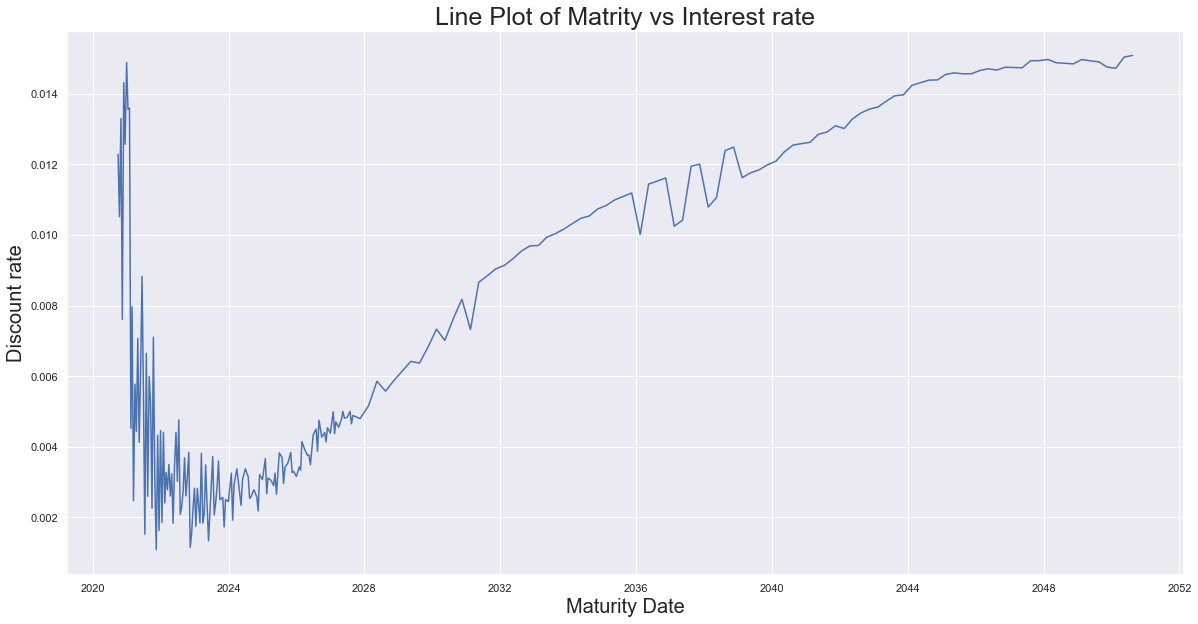

In [39]:
#Line plot of dates vs discount rates
plt.figure(figsize=(20,10))
plt.plot(disc_rates.index,disc_rates.Rates)
plt.title('Line Plot of Matrity vs Interest rate', fontsize = 25)
plt.xlabel('Maturity Date', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)

Text(0, 0.5, 'Discount rate')

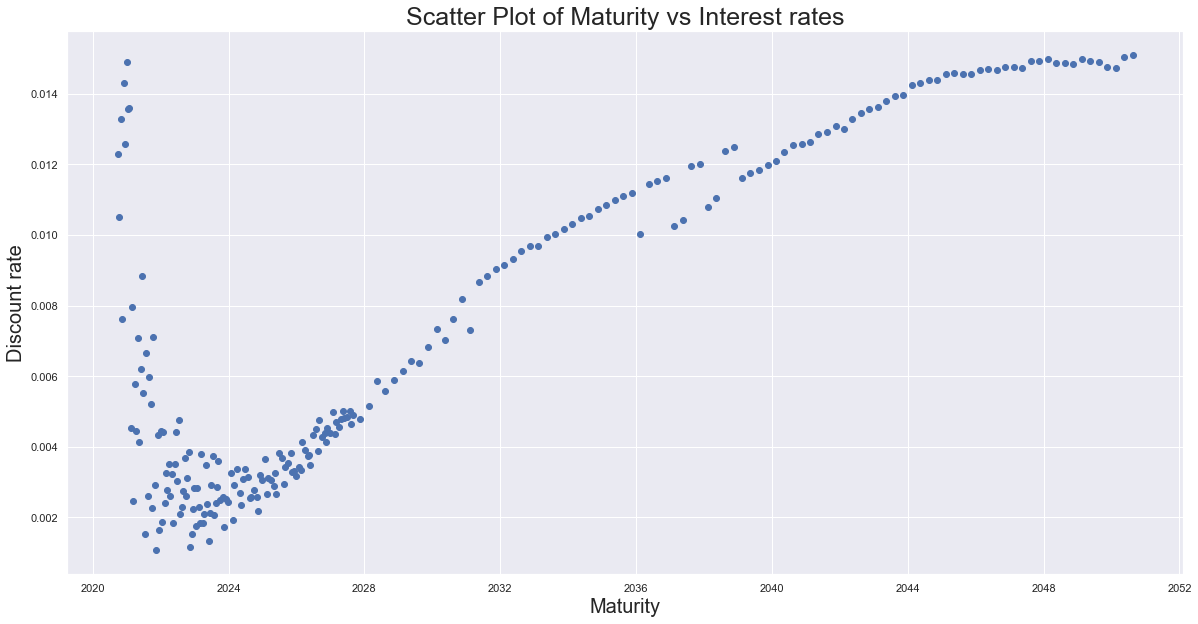

In [40]:
#Scatter plot of dates vs discount rates
plt.figure(figsize=(20,10))
plt.scatter(disc_rates.index,disc_rates.Rates)
plt.title('Scatter Plot of Maturity vs Interest rates', fontsize = 25)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)

## Removing Outliers

In [41]:
disc_rates_f = disc_rates[disc_rates.Rates < 0.06]
disc_rates_f['Mat_Time'] = (disc_rates_f.index - date0).days/365.25

## Fitting a smooth curve through the spine using Spline and Gaussian Filter

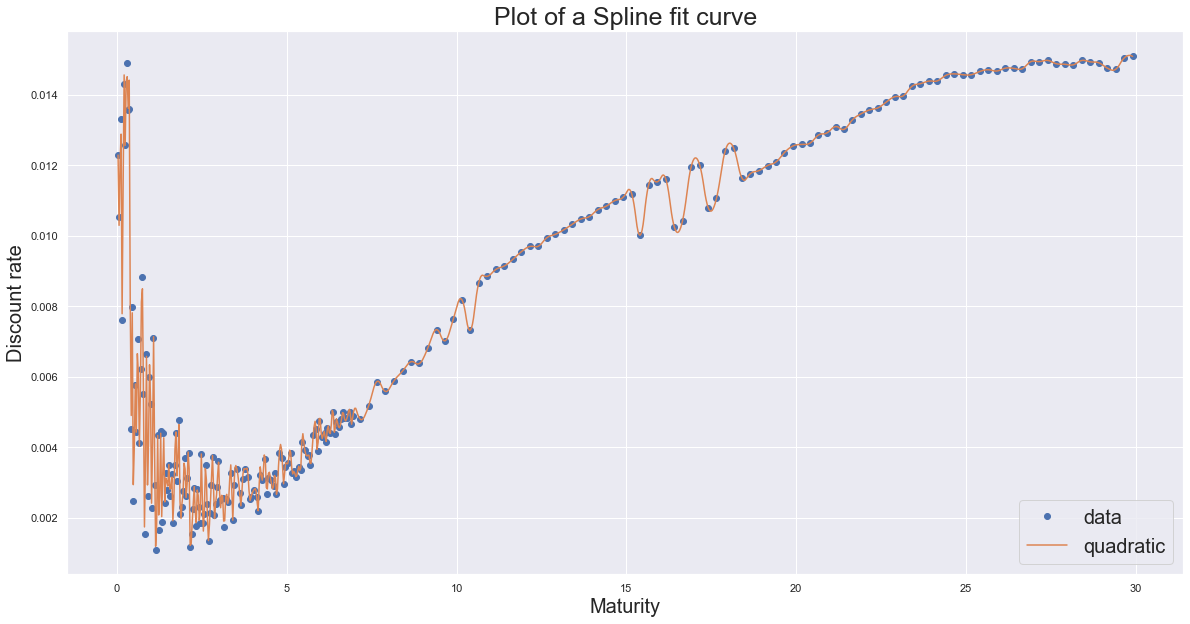

In [42]:
from scipy.interpolate import interp1d
fit = 'quadratic'
f = interp1d(disc_rates_f.Mat_Time, disc_rates_f.Rates, kind = fit)
mat_times_granular = np.linspace(disc_rates_f.Mat_Time.min(), disc_rates_f.Mat_Time.max(), num=1000, endpoint=True)

plt.figure(figsize=(20,10))
plt.title('Plot of a Spline fit curve', fontsize = 25)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)
plt.plot(disc_rates_f.Mat_Time, disc_rates_f.Rates , 'o', mat_times_granular, f(mat_times_granular), '-')
plt.legend(['data', fit], loc='best', prop={'size': 20})

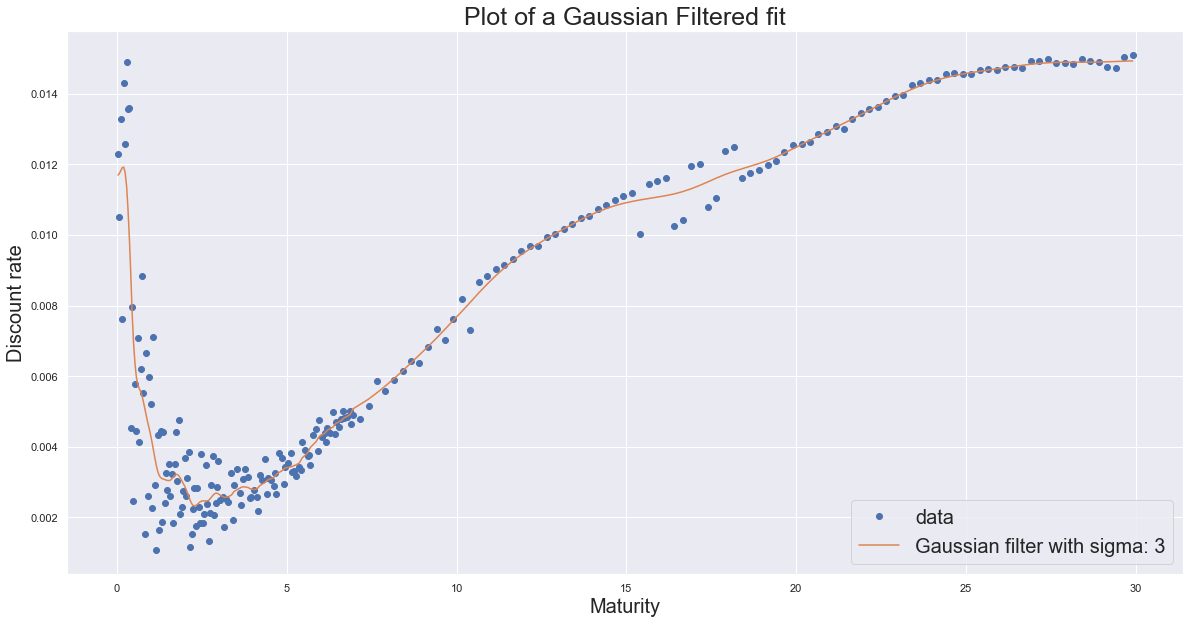

In [43]:
from scipy.ndimage.filters import gaussian_filter1d
sig = 3
rates_smoothg = gaussian_filter1d(disc_rates_f.Rates, sigma = sig)

plt.figure(figsize=(20,10))
plt.title('Plot of a Gaussian Filtered fit', fontsize = 25)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)
plt.plot(disc_rates_f.Mat_Time, disc_rates_f.Rates , 'o', disc_rates_f.Mat_Time, rates_smoothg)
plt.legend(['data','Gaussian filter with sigma: ' + str(sig)], prop={'size': 20})